In [1]:
# Import required python libraries
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
plt.rcParams.update({'font.size': 12})

### <u>Define the true function<u>

Let the true function to be modeled (interpolated) be
$$ h(x) = \sin\left(x\right) + \frac{x}{4}, \hspace{2em} x\in [-5,5] $$

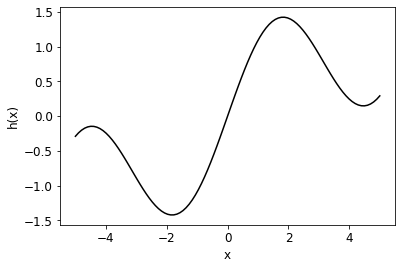

In [2]:
# Define the true function
def h(x):
    return (np.sin(x) + 0.25*x).flatten()

# Visualize the true function
plt.plot(np.linspace(-5,5,100), h(np.linspace(-5,5,100)), c = 'black')
plt.xlabel("x")
plt.ylabel("h(x)")
plt.show()

### <u>Define the covariance function<u>

Next, define the covariance function for the Gaussian process regression as the squared exponential function
$$ k(x_i, x_j) = \exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\delta^2} \right)$$

Notice that we have one hyperparameter, i.e., length scale $\delta$

In [3]:
def covariance_function(X1, X2, delta = 1.0, sigma_f = 1.0):
    '''
    Isotropic squared exponential covariance. 
    Computes a covariance matrix from points in X1 and X2.
    (Signal variance sigma_f = 1.0 throughout this tutorial for simplicity)
        
    Args:
        X1 : Array of m points (m x d)
        X2 : Array of n points (n x d)

    Returns:
        Covariance matrix (m x n)
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / delta**2 * sqdist)

### <u>Simulate GPR for different scenarios<u>

In [4]:
def simulate_gp(n, delta):
    '''
    Function to simulate a GP to approximate the true function h(x) defined above.
    
    Args:
        n     : Number of observations in the domain [-5, 5]
        delta : length scale hyperparameter for the squared exponential covariance
        
    '''
    np.random.seed(3)   # Seed for repeatability

    n_observed = n      # Number of observations
    n_predict = 100     # Number of points at which predictions are to be made
    s_2 = 5e-04         # Measurement noise

    # First, sample observations on the domain randomly
    # and evaluate the true function with some measurement noise
    X_observed = np.random.uniform(-5, 5, size = (n_observed, 1))
    y_observed = h(X_observed) + s_2*np.random.randn(n_observed)

    # Get the predicted points uniformly spaced in the domain
    X_predict = np.linspace(-5, 5, n_predict).reshape(-1,1)

    # Define the covariance matrices
    K = covariance_function(X_observed, X_observed, delta)
    K_star = covariance_function(X_observed, X_predict, delta)
    K_star_star = covariance_function(X_predict, X_predict, delta)

    # Get the predicted mean and standard deviation
    mu = K_star.T.dot(np.linalg.inv(K + s_2*np.eye(n_observed)).dot(y_observed))
    var = np.diag(K_star_star - K_star.T.dot(np.linalg.inv(K + s_2*np.eye(n_observed)).dot(K_star)))
    std = np.sqrt(var)

    # For better visualization, let's pick 10 random samples from the prior and posterior distributions
    L1 = np.linalg.cholesky(K + s_2*np.eye(n_observed))
    L2 = np.linalg.solve(L1, K_star)
    L3 = np.linalg.cholesky(K_star_star + 1e-6*np.eye(n_predict))
    L4 = np.linalg.cholesky(K_star_star + 1e-6*np.eye(n_predict) - np.dot(L2.T, L2))
    samples = np.random.normal(size = (n_predict, 10))
    prior_samples = np.dot(L3, samples)
    posterior_samples = mu.reshape(-1,1) + np.dot(L4, samples)

    # Now plot the prior, posterior, and the posterior mean and stdev
    fig, axarr = plt.subplots(1, 3, figsize = (16, 4))
    axarr[0].plot(X_predict, prior_samples)
    axarr[0].axis([-5, 5, -3, 3])
    axarr[0].set_title("10 samples from the prior")
    axarr[0].set_xlabel("x")
    axarr[0].set_ylabel("h")
    axarr[1].plot(X_predict, posterior_samples)
    axarr[1].plot(X_observed, y_observed, 'ro', ms = 10)
    axarr[1].axis([-5, 5, -3, 3])
    axarr[1].set_title("10 samples from the posterior")
    axarr[1].set_xlabel("x")
    axarr[1].set_ylabel("h")
    axarr[2].fill_between(X_predict.flat, mu-std, mu+std, color="#dddddd")
    axarr[2].plot(X_predict, mu, 'r--', lw=2)
    axarr[2].plot(X_observed, y_observed, 'ro', ms=10)
    axarr[2].set_title("Posterior mean and stdev")
    axarr[2].axis([-5, 5, -3, 3])
    axarr[2].set_xlabel("x")
    axarr[2].set_ylabel("h")
    plt.show()

Let's first consider the case when there are no observations in the domain.

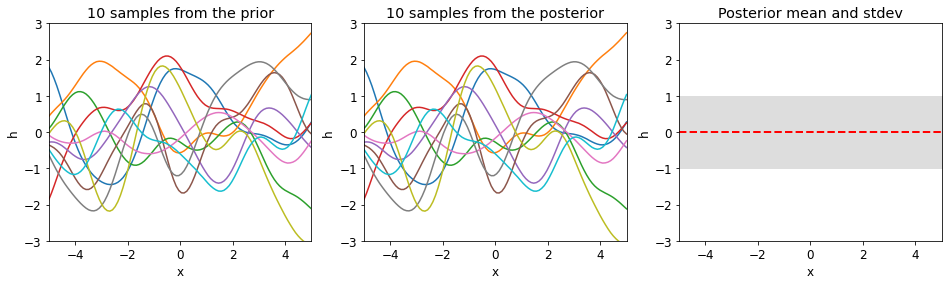

In [5]:
simulate_gp(n = 0, delta = 1.0)

Notice that the prior and posterior are identical. This is because the posterior has no data in order to update the prior belief. Also, as expected, the posterior mean and standard deviation are 0 and 1 throughout the domain, respectively.

Next, let's observe one datapoint $x$ and its corresponding value $h(x)$.

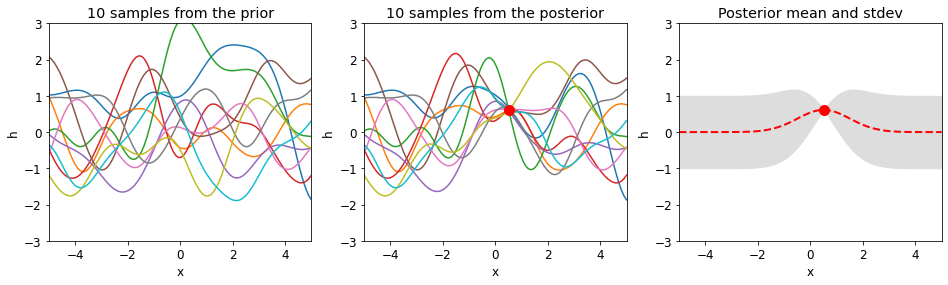

In [6]:
simulate_gp(n = 1, delta = 1.0)

We see that the prior remains unchanged, but the posterior changes to accommodate the observation. All samples in the posterior now pass through the observed point. The posterior mean and standard deviation also change. Notice how the standard deviation (prediction uncertainty) is reduced close to the observation.

Let's see what happens when we successively add 5 observations.

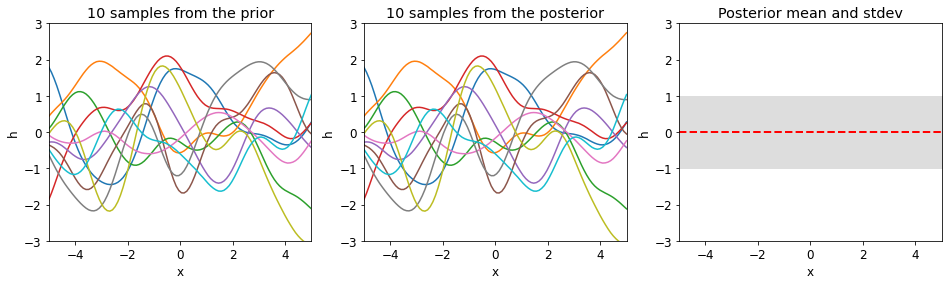

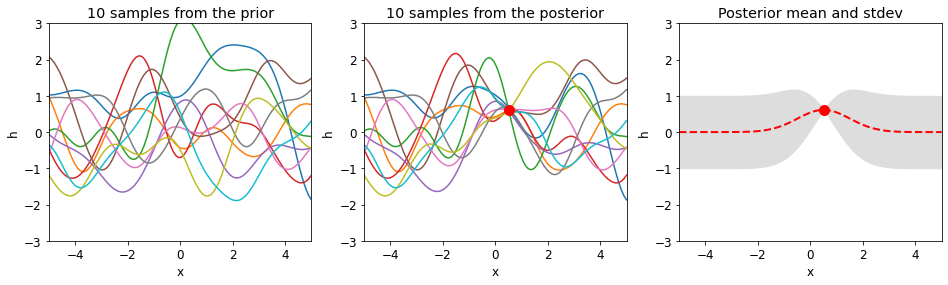

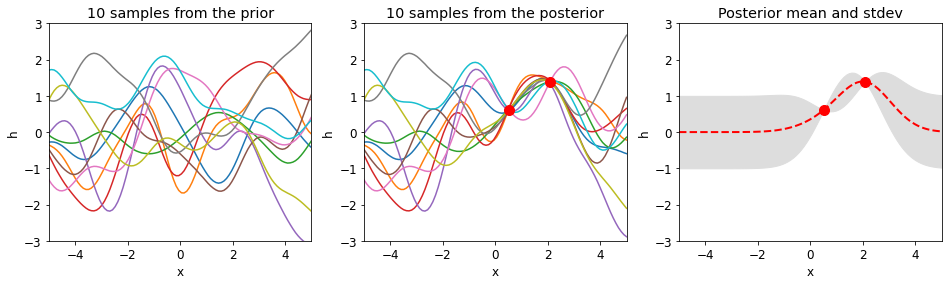

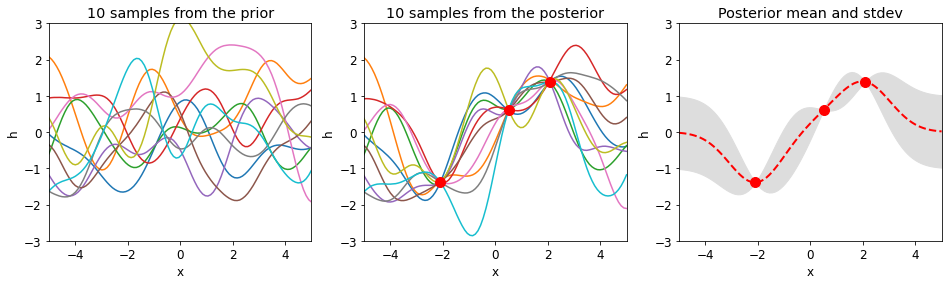

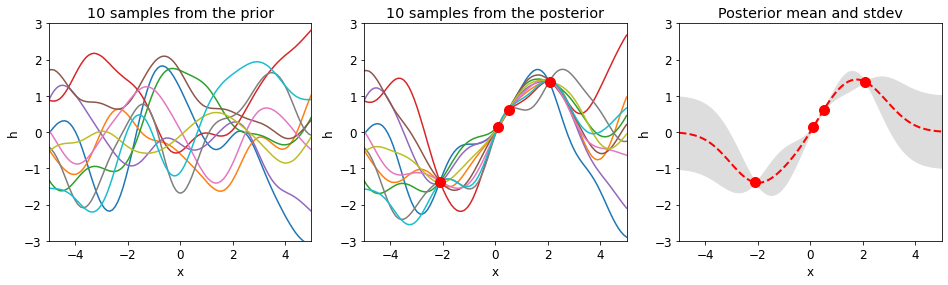

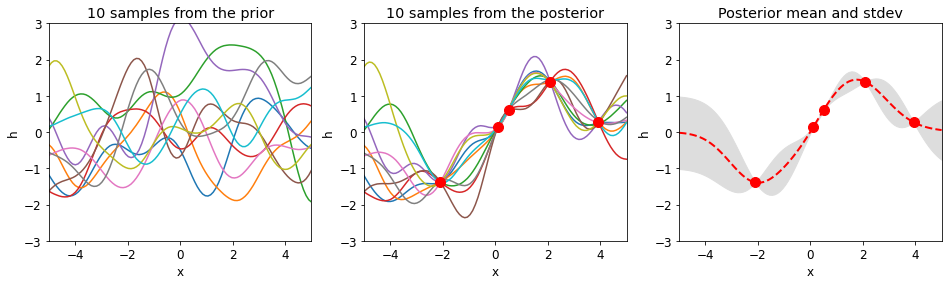

In [7]:
for i in range(6):
    simulate_gp(n = i, delta = 1.0)

The posterior mean changes to account for the observations, and so does the standard deviation close across the domain. As more obsrvations are added, the GP starts approximating the true function $h(x)$ better.

For the above experiments, we fixed the hyperparameter $\delta = 1.0$. Let's use two different values of $\delta$ viz. $\delta = 10.0$ and $\delta = 0.5$ and observe the model.

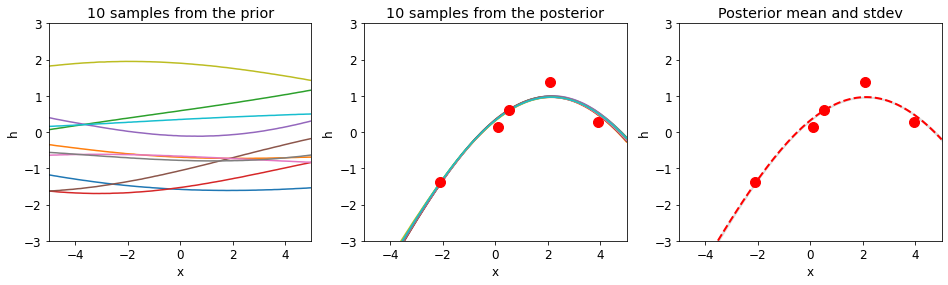

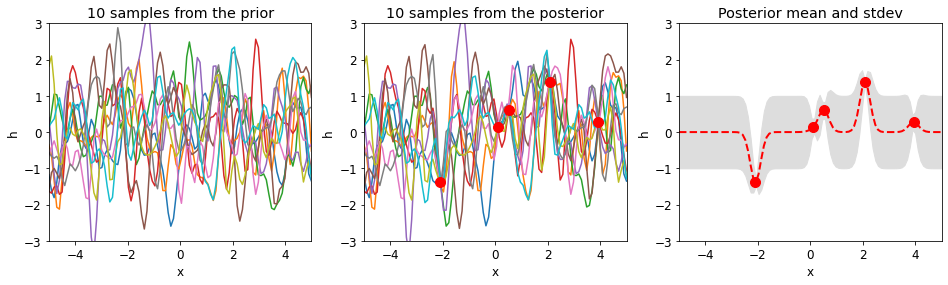

In [8]:
simulate_gp(n = 5, delta = 10.0) # Simulate a GP with a very large length scale
simulate_gp(n = 5, delta = 0.2)  # Simulate a GP with a very small length scale

We see that the behavior of the GP depends on the length scale hyperparameter. Both the above models have poor expressivity for the observed data. We must select hyperparameter $\delta$ such that it best explains the observed data. We can perform this optimization using the `sklearn` library in Python.

https://scikit-learn.org/stable/modules/gaussian_process.html

### <u>GPR with the `sklearn` package in Python<u>

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor # Helps us define and fit GPR models easily
from sklearn.gaussian_process.kernels import RBF # The covariance we used above is called RBF kernel in sklearn

In [10]:
# Define the squared exponential function in sklearn and see its hyperparameter
my_kernel = RBF(length_scale = 1.0, length_scale_bounds = (1e-03, 1e03))
my_kernel.get_params()

{'length_scale': 1.0, 'length_scale_bounds': (0.001, 1000.0)}

In [11]:
# Resample the observed points from the simulations above
np.random.seed(3)   # Seed for repeatability
n_observed = 5      # Number of observations
n_predict = 100     # Number of points at which predictions are to be made
s_2 = 5e-04         # Measurement noise

X_observed = np.random.uniform(-5, 5, size = (n_observed, 1))
y_observed = h(X_observed) + s_2*np.random.randn(n_observed)
X_predict = np.linspace(-5, 5, n_predict).reshape(-1,1)

In [12]:
# Fit the GP model
gpr = GaussianProcessRegressor(kernel = my_kernel, random_state = 0)
gpr.fit(X_observed, y_observed)

# When the 'fit' method is called above, sklearn automatically optimizes the kernel hyperparameter
print("The optimal kernel found is", gpr.kernel_)
print("The optimal length scale = ", np.round(gpr.kernel_.get_params()['length_scale'], 3))

The optimal kernel found is RBF(length_scale=1.88)
The optimal length scale =  1.878


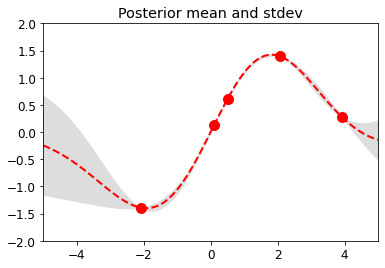

In [13]:
# Calculate the posterior mean and standard deviation on the rest of the domain
# using the optimized model
# The 'predict' method in sklearn does this for us
mu, std = gpr.predict(X_predict, return_std = True)

# Plot the optimized GPR model
plt.figure(figsize = (6, 4))
plt.fill_between(X_predict.flat, mu-std, mu+std, color="#dddddd")
plt.plot(X_predict, mu, 'r--', lw=2)
plt.plot(X_observed, y_observed, 'ro', ms = 10)
plt.title('Posterior mean and stdev')
plt.axis([-5, 5, -2, 2])
plt.show()